### *This is an example to run top_secret.py in the notebook at the current notebooks folder

#### *Run this cell to resolve import issues*

In [16]:
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

#### This part has imbalanced tarining data

target:MARSOL
Soft Train score: 0.975975975975976 Soft Test score: 0.9372197309417041
Hard Train score: 0.9474474474474475 Hard Test score: 0.9327354260089686
RFC Train score: 1.0 RFC Test score: 0.968609865470852
KNN Train score: 0.9414414414414415 KNN Test score: 0.9327354260089686
Hard Vote Confusion Matrix:


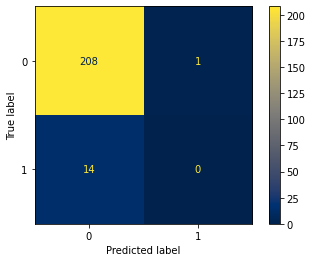

RF Confusion Matrix:


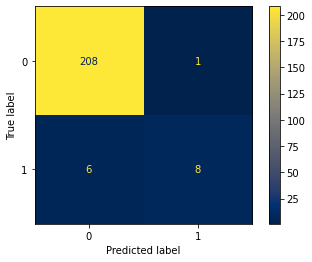

KNN Confusion Matrix:


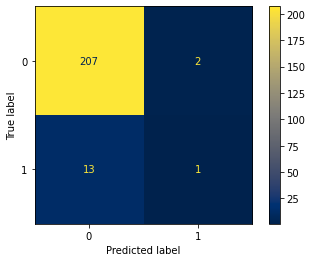

In [17]:
from log_parser import parse_keyboard_log
from log_parser import parse_mouse_log
from keyboard_heatmap import KeyboardHeatmap
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler


# Set to false to test non-binary classification
test_binary = True

# List of parsed logfiles
keyboard = []
mouse = []

# Read logfile paths from .routing
with open("../.routing", 'r', encoding='utf-8') as f:
    log_paths = f.read().splitlines()   # Read lines without '\n's
    for path in log_paths:
        if 'key.log' in path:
            keyboard.append(parse_keyboard_log('../' + path))
        elif 'mouse.log' in path:
            mouse.append(parse_mouse_log('../' + path))

# 60 second segments fuggetaboutit
train_seg_length = 60
test_seg_length = 60
# The quintessential target class
target = "MARSOL"

# Empty lists for inserting data
X_actual = []
Y_actual = []

# For confusion matrix plotting
labels = []

for k in range(len(keyboard)):
    l = None
    for i in range(int(keyboard[k].time.iloc[-1] / train_seg_length)):
        # For each segment in each logfile
        # Create a heatmap for that segment
        heatmap = KeyboardHeatmap(keyboard[k], i, train_seg_length)
        if test_binary: heatmap = heatmap.to_binary_class_label(target)
        # If the heatmap isn't blank
        if heatmap.class_label() != 'Null':
            X_actual.append(heatmap.heatmap_data().ravel().tolist())
            Y_actual.append(heatmap.class_label())
        
        l = heatmap.class_label()
    labels.append(l)

X_train, X_test, Y_train, Y_test = train_test_split(X_actual, Y_actual, random_state=0)
'''
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
X_train, Y_train = undersample.fit_resample(X_train, Y_train)
'''
# ensemble of models
estimator = []
estimator.append(('RF', RandomForestClassifier(
    n_jobs=-1, 
    criterion='gini',
    max_features= 'sqrt',
    n_estimators = 100, 
    oob_score = True)))
estimator.append(('KNN', KNeighborsClassifier(
    n_neighbors=5 # we dont talk about this number
    )))

print("target:" + target)

# Voting Classifier with soft voting
vot_soft = VotingClassifier(estimators = estimator, voting ='soft')
vot_soft.fit(X_train, Y_train)

print( f"Soft Train score: {vot_soft.score(X_train, Y_train)} " + f"Soft Test score: {vot_soft.score(X_test, Y_test)}")

# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
vot_hard.fit(X_train, Y_train)

print( f"Hard Train score: {vot_hard.score(X_train, Y_train)} " + f"Hard Test score: {vot_hard.score(X_test, Y_test)}")

rfc = RandomForestClassifier(n_jobs=-1, criterion='gini', max_features= 'sqrt', n_estimators = 100, oob_score = True) 
rfc.fit(X_train, Y_train)
print( f"RFC Train score: {rfc.score(X_train, Y_train)} " + f"RFC Test score: {rfc.score(X_test, Y_test)}")

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, Y_train)
print( f"KNN Train score: {knn.score(X_train, Y_train)} " + f"KNN Test score: {knn.score(X_test, Y_test)}")


# Plotting
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

if test_binary:
    print("Hard Vote Confusion Matrix:")
    y_rf_predict = vot_hard.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(Y_test, y_rf_predict, cmap='cividis')
    plt.show()

    print("RF Confusion Matrix:")
    y_rf_predict = rfc.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(Y_test, y_rf_predict, cmap='cividis')
    plt.show()

    print("KNN Confusion Matrix:")
    y_rf_predict = knn.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(Y_test, y_rf_predict, cmap='cividis')
    plt.show()

else:

    fig, ax = plt.subplots(3, figsize=(10,30))

    ax[0].set_title("Hard Vote Confusion Matrix:")
    y_rf_predict = vot_hard.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(Y_test, y_rf_predict, cmap='cividis', xticks_rotation=-45.0, labels=labels, ax=ax[0])

    ax[1].set_title("RF Confusion Matrix:")
    y_rf_predict = rfc.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(Y_test, y_rf_predict, cmap='cividis', xticks_rotation=-45.0, labels=labels, ax=ax[1])

    ax[2].set_title("KNN Confusion Matrix:")
    y_rf_predict = knn.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(Y_test, y_rf_predict, cmap='cividis', xticks_rotation=-45.0, labels=labels, ax=ax[2])

#### Below is the same code as above but with under sampling on the negative training data

target:MARSOL
Soft Train score: 0.9891304347826086 Soft Test score: 0.820627802690583
Hard Train score: 0.9456521739130435 Hard Test score: 0.8475336322869955
RFC Train score: 1.0 RFC Test score: 0.8251121076233184
KNN Train score: 0.8152173913043478 KNN Test score: 0.6098654708520179
Hard Vote Confusion Matrix:


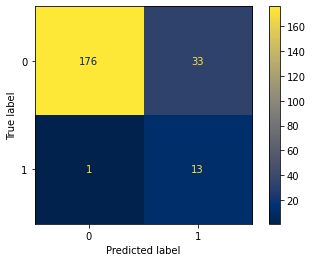

RF Confusion Matrix:


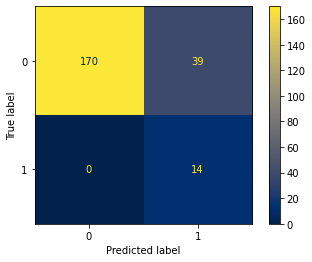

KNN Confusion Matrix:


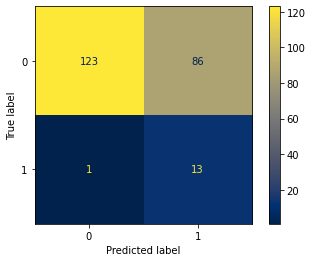

In [18]:
from log_parser import parse_keyboard_log
from log_parser import parse_mouse_log
from keyboard_heatmap import KeyboardHeatmap
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler


# Set to false to test non-binary classification
test_binary = True

# List of parsed logfiles
keyboard = []
mouse = []

# Read logfile paths from .routing
with open("../.routing", 'r', encoding='utf-8') as f:
    log_paths = f.read().splitlines()   # Read lines without '\n's
    for path in log_paths:
        if 'key.log' in path:
            keyboard.append(parse_keyboard_log('../' + path))
        elif 'mouse.log' in path:
            mouse.append(parse_mouse_log('../' + path))

# 60 second segments fuggetaboutit
train_seg_length = 60
test_seg_length = 60
# The quintessential target class
target = "MARSOL"

# Empty lists for inserting data
X_actual = []
Y_actual = []

# For confusion matrix plotting
labels = []

for k in range(len(keyboard)):
    l = None
    for i in range(int(keyboard[k].time.iloc[-1] / train_seg_length)):
        # For each segment in each logfile
        # Create a heatmap for that segment
        heatmap = KeyboardHeatmap(keyboard[k], i, train_seg_length)
        if test_binary: heatmap = heatmap.to_binary_class_label(target)
        # If the heatmap isn't blank
        if heatmap.class_label() != 'Null':
            X_actual.append(heatmap.heatmap_data().ravel().tolist())
            Y_actual.append(heatmap.class_label())
        
        l = heatmap.class_label()
    labels.append(l)

X_train, X_test, Y_train, Y_test = train_test_split(X_actual, Y_actual, random_state=0)

# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
X_train, Y_train = undersample.fit_resample(X_train, Y_train)

# ensemble of models
estimator = []
estimator.append(('RF', RandomForestClassifier(
    n_jobs=-1, 
    criterion='gini',
    max_features= 'sqrt',
    n_estimators = 100, 
    oob_score = True)))
estimator.append(('KNN', KNeighborsClassifier(
    n_neighbors=5 # we dont talk about this number
    )))

print("target:" + target)

# Voting Classifier with soft voting
vot_soft = VotingClassifier(estimators = estimator, voting ='soft')
vot_soft.fit(X_train, Y_train)

print( f"Soft Train score: {vot_soft.score(X_train, Y_train)} " + f"Soft Test score: {vot_soft.score(X_test, Y_test)}")

# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
vot_hard.fit(X_train, Y_train)

print( f"Hard Train score: {vot_hard.score(X_train, Y_train)} " + f"Hard Test score: {vot_hard.score(X_test, Y_test)}")

rfc = RandomForestClassifier(n_jobs=-1, criterion='gini', max_features= 'sqrt', n_estimators = 100, oob_score = True) 
rfc.fit(X_train, Y_train)
print( f"RFC Train score: {rfc.score(X_train, Y_train)} " + f"RFC Test score: {rfc.score(X_test, Y_test)}")

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, Y_train)
print( f"KNN Train score: {knn.score(X_train, Y_train)} " + f"KNN Test score: {knn.score(X_test, Y_test)}")


# Plotting
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

if test_binary:
    print("Hard Vote Confusion Matrix:")
    y_rf_predict = vot_hard.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(Y_test, y_rf_predict, cmap='cividis')
    plt.show()

    print("RF Confusion Matrix:")
    y_rf_predict = rfc.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(Y_test, y_rf_predict, cmap='cividis')
    plt.show()

    print("KNN Confusion Matrix:")
    y_rf_predict = knn.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(Y_test, y_rf_predict, cmap='cividis')
    plt.show()

else:

    fig, ax = plt.subplots(3, figsize=(10,30))

    ax[0].set_title("Hard Vote Confusion Matrix:")
    y_rf_predict = vot_hard.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(Y_test, y_rf_predict, cmap='cividis', xticks_rotation=-45.0, labels=labels, ax=ax[0])

    ax[1].set_title("RF Confusion Matrix:")
    y_rf_predict = rfc.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(Y_test, y_rf_predict, cmap='cividis', xticks_rotation=-45.0, labels=labels, ax=ax[1])

    ax[2].set_title("KNN Confusion Matrix:")
    y_rf_predict = knn.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(Y_test, y_rf_predict, cmap='cividis', xticks_rotation=-45.0, labels=labels, ax=ax[2])